# BLEU: Evaluation Metric 


A Gentle Introduction to Calculating the BLEU Score for Text in Python
by Jason Brownlee on November 20, 2017 in Deep Learning for Natural Language Processing
BLEU, or the Bilingual Evaluation Understudy, is a score for comparing a candidate translation of text to one or more reference translations.

Although developed for translation, it can be used to evaluate text generated for a suite of natural language processing tasks.

Here, we will discover the BLEU score for evaluating and scoring candidate text using the NLTK library in Python.

The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.

A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

The score was developed for evaluating the predictions made by automatic machine translation systems. It is not perfect, but does offer 5 compelling benefits:

It is quick and inexpensive to calculate.
It is easy to understand.
It is language independent.
It correlates highly with human evaluation.
It has been widely adopted.
The BLEU score was proposed by Kishore Papineni, et al. in their 2002 paper “BLEU: a Method for Automatic Evaluation of Machine Translation“.

The approach works by counting matching n-grams in the candidate translation to n-grams in the reference text, where 1-gram or unigram would be each token and a bigram comparison would be each word pair.

In [12]:
import csv
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from numpy import array
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu

In [2]:
def load_descriptions(filename,dataset):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        description_dict = {}
        for row in reader:
            im_id = row[0]
            description = row[1]
            if im_id in dataset:
                if im_id not in description_dict:
                    description_dict[im_id] = []
                description = 'startq ' + description + ' endq'
                description_dict[im_id].append(description)
        return description_dict
    

In [3]:
def load_identifiers(filename):
    with open(filename, 'r') as file:
        content = file.read()
        dataset = []
        for line in content.split('\n'):
            if len(line)>0:
                im_id = line.split('.')[0]
                dataset.append(im_id)
    return list(set(dataset))  

In [4]:
def load_image_features(filename,dataset):
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        image_features = {}

        i=0
        for row in reader:
            i= i+1
            #print(i)
            features = row[1:]
            features = [float(i) for i in features]
            im_id = row[0]
            #print(im_id)
            if im_id in dataset:
                image_features[im_id] = features
        return image_features

In [5]:
def to_lines(descriptions):
    descriptions_list = []
    for key in descriptions:
        for value in descriptions[key]:
            descriptions_list.append(value)
    return descriptions_list

In [6]:
def tokenize(descriptions):
    all_lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_lines)
    return tokenizer

In [7]:
def find_word_using_id(value, tokenizer):
    for word,index in tokenizer.word_index.items():
        if index == value:
            return word
    return None

In [8]:
def generate_desc(model, tokenizer,photo,max_length):
    in_text = 'startq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen = max_length)
        yhat = model.predict([array([photo]),array(sequence)])
        yhat = argmax(yhat)
        word = find_word_using_id(yhat, tokenizer)
        #print(word)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endq':
            break
    return in_text

In [9]:
def evaluate_model(model,descriptions,features,tokenizer,max_length):
    actual =[]
    predicted = []
    for key, desc_list in descriptions.items():
        yhat = generate_desc(model, tokenizer, features[key],max_length)
        #print(yhat)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    print('BLEU-1 = ' + str(corpus_bleu(actual,predicted,weights=(1.0,0,0,0))))
    print('BLEU-2 = ' + str(corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0))))
    print('BLEU-3 = ' + str(corpus_bleu(actual,predicted,weights=(0.33,0.33,0.33,0))))
    print('BLEU-4 = ' + str(corpus_bleu(actual,predicted,weights=(0.25,0.25,0.25,0.25))))

In [10]:
def find_max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [11]:
filename = 'dataset/textData/Flickr_8k.trainImages.txt'
train = load_identifiers(filename)
train_desc = load_descriptions('dataset/textData/clean_vocab.csv', train)
tokenizer = tokenize(train_desc)
vocab_size = len(tokenizer.word_index) + 1
max_length = find_max_length(train_desc)

filename = 'dataset/textData/Flickr_8k.testImages.txt'
test = load_identifiers(filename)
test_desc = load_descriptions('dataset/textData/clean_vocab.csv', test)
#print(len(test))
tokenizer = tokenize(test_desc)

filename = 'model-ep004-loss3.058-val_loss3.616.h5'
model = load_model(filename)
test_features = load_image_features('features.csv',test)
#print(test_features.keys())
evaluate_model(model, test_desc, test_features, tokenizer, max_length)


BLEU-1 = 0.6683701975219377
BLEU-2 = 0.45777912576951124
BLEU-3 = 0.31993177555255
BLEU-4 = 0.21121417634639494


# Generating Captions

In [18]:
def plot(image_id,features):
    img = cv2.imread('dataset/imgData/' + image_id + '.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    yhat = generate_desc(model, tokenizer, features[image_id], max_length)
    print(yhat)

In [16]:
import matplotlib.pyplot as plt
import cv2

filename = 'dataset/textData/Flickr_8k.testImages.txt'
test = load_identifiers(filename)
test_features = load_image_features('features.csv',test)

startq the baseball player in the orange uniform is playing to the ball endq


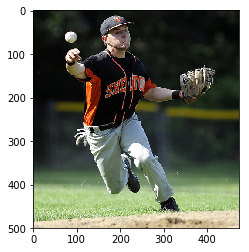

In [19]:
plot('3603116579_4a28a932e2',test_features)

startq greyhound greyhound racing on track endq


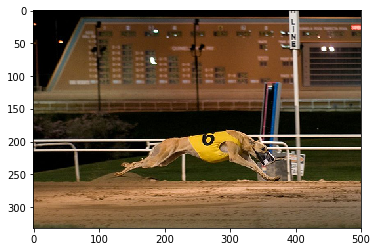

In [20]:
plot('2469498117_b4543e1460',test_features)

startq boy in red shirt is holding her arms endq


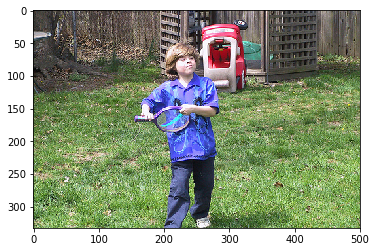

In [21]:
plot('3465606652_f380a38050',test_features)

startq boy in blue uniform is playing basketball endq


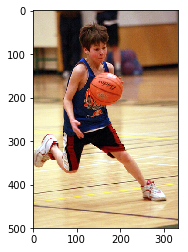

In [23]:
plot('2293424366_7b5fcd2398',test_features)

startq man is standing on snowy mountain endq


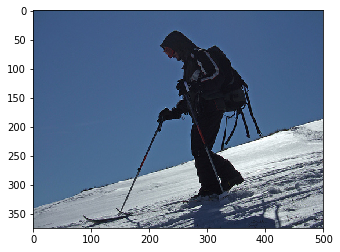

In [24]:
plot('1397923690_d3bf1f799e',test_features)